**Which soccer team shirt is this?**

If you follow soccer, you probably know that soccer team shirts may either look nothing like each other or be completely similar (for example, the Juventus jersey vs the Newcastle United one). In this project, we'll build a classifier that predicts which soccer team a given shirt belongs to and try to see if we can set apart similar ones.

In this project, we'll establish two main objectives:


1 - See if we can differentiate the uniforms of the twenty clubs that took part in the Series A Brazilian Championship (Brasileirão) in the year of 2024 and

2 - See if we can differentiate teams with look-alike uniforms. In this case, we'll try and differentiate Botafogo's jersey from other stripe-based team shirts.

**Classifying the Botafogo shirt from other Brazilian teams**

In [2]:
# Some setup first
!pip install -Uqq fastai 'duckduckgo_search>=6.2'
from duckduckgo_search import DDGS
from fastcore.all import *
import time, json

def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')


In [66]:
target_team = "Botafogo"
teams_brazil_league = ["Palmeiras", "Atlético-MG", "Flamengo", "Grêmio", "Red Bull Bragantino", "Fluminense", "Athletico-PR", "Internacional", "Fortaleza", "São Paulo", "Cuiabá", "Corinthians", "Cruzeiro", "Vasco", "Bahia", "Vitória", "Juventude", "Criciúma", "Atlético-GO"]

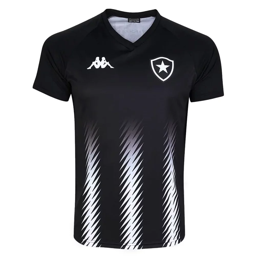

In [4]:
# Since Botafogo is a brazilian club, we'll have the search query be in Brazilian Portuguese. "camisa botafogo" translates to "botafogo shirt"
urls = search_images('camisa botafogo', max_images=1)

# We search for a Botafogo jersey image as a reference
from fastdownload import download_url
dest = 'botafogo_camisa.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)


In [7]:
#Search and download example t-shirt images for the teams in the brazilian league
path = Path('botafogo_or_not')

if target_team not in teams_brazil_league:
    teams_brazil_league.append(target_team)

for o in teams_brazil_league:
    print(f"downloading t-shirt images for {o}")
    dest = (path/o)
    if not os.path.isdir(dest):
        dest.mkdir(exist_ok=False, parents=True)
        download_images(dest, urls=search_images(f'{o} camisa oficial 2024')) #search query translates to "some_team official t-shirt 2024"
        print("sleeping...")
        time.sleep(50)
        resize_images(path/o, max_size=400, dest=path/o)

downloading t-shirt images for Palmeiras
downloading t-shirt images for Atlético-MG
downloading t-shirt images for Flamengo
downloading t-shirt images for Grêmio
downloading t-shirt images for Red Bull Bragantino
downloading t-shirt images for Fluminense
downloading t-shirt images for Athletico-PR
downloading t-shirt images for Internacional
downloading t-shirt images for Fortaleza
downloading t-shirt images for São Paulo
downloading t-shirt images for Cuiabá
downloading t-shirt images for Corinthians
downloading t-shirt images for Cruzeiro
downloading t-shirt images for Vasco
downloading t-shirt images for Bahia
downloading t-shirt images for Vitória
sleeping...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


downloading t-shirt images for Juventude
sleeping...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


downloading t-shirt images for Criciúma
sleeping...
downloading t-shirt images for Atlético-GO
sleeping...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


downloading t-shirt images for Botafogo
sleeping...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Now that we've downloaded a bunch of images, let's remove the ones that failed

In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
print("Images failed:" + str(len(failed)))
print("Sucessful images:" + str(len(get_image_files(path))))

Images failed:53
Sucessful images:3584


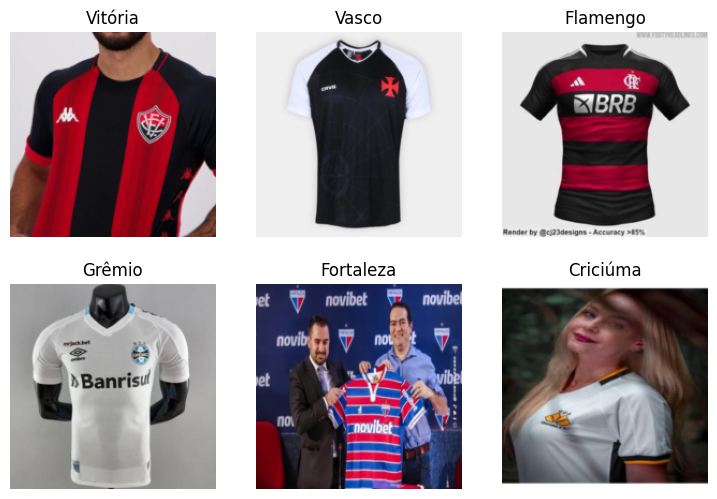

In [9]:
#Let's get our data structured so we can work with it
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

#let's check a few examples
dls.show_batch(max_n=6)

Let's start by training our model on a few epochs.

**Training the model**

In [31]:
#Now we train our model
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(7)

epoch,train_loss,valid_loss,error_rate,time
0,3.341846,2.286899,0.589385,00:08


epoch,train_loss,valid_loss,error_rate,time
0,2.121625,1.831221,0.481844,00:09
1,1.663765,1.663509,0.409218,00:09
2,1.220480,1.499463,0.377095,00:09
3,0.897311,1.468392,0.349162,00:08
4,0.676068,1.446897,0.357542,00:08
5,0.511193,1.421095,0.349162,00:08
6,0.415891,1.411208,0.349162,00:08


Let's see if our model can predict a few valid cases, where I grabbed images from the web instead of using the dataset:

In [67]:
#Predict the Botafogo shirt
team_shirt,_,probs = learn.predict(PILImage.create('botafogo_camisa.jpg'))
print(f"This is a: {team_shirt} shirt.")

#Predict the Palmeiras shirt
team_shirt,_,probs = learn.predict(PILImage.create('camisa_palmeiras.jpg'))
print(f"This is a: {team_shirt} shirt.")

#Predict the Atletico-MG shirt
team_shirt,_,probs = learn.predict(PILImage.create('camisa_atletico_mg.jpg'))
print(f"This is a: {team_shirt} shirt.")

This is a: Botafogo shirt.


This is a: Palmeiras shirt.


This is a: Atletico-MG shirt.


Great! It seems our model is able to differentiate between shirts, including the ones that look the most similar (Botafogo and Atletico-MG). However, our error rate is somewhat high at almost 35%. Maybe we can reduce it by training more epochs?

In [40]:
#We re-train the model for 20 epochs
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(20)

epoch,train_loss,valid_loss,error_rate,time
0,3.326484,2.160868,0.592179,00:07


epoch,train_loss,valid_loss,error_rate,time
0,2.045743,1.830053,0.495810,00:08
1,1.635938,1.656471,0.444134,00:08
2,1.352184,1.634087,0.414804,00:08
3,1.099156,1.613907,0.396648,00:08
4,0.937645,1.556867,0.367318,00:08
5,0.795098,1.541302,0.382682,00:08
6,0.687909,1.486404,0.370112,00:08
7,0.635632,1.438710,0.351955,00:08
8,0.568072,1.482186,0.342179,00:09
9,0.524803,1.360129,0.332402,00:08


Well, we're still getting a high error rate while our valid loss isn't getting significantly lower. This might indicate our model is overfitting, so we'll try a different approach.

**Cleaning data**

The next step we can take then is to visually inspect our data and see if there are any clues. Let's look at a few examples from the "Corinthians" folder:

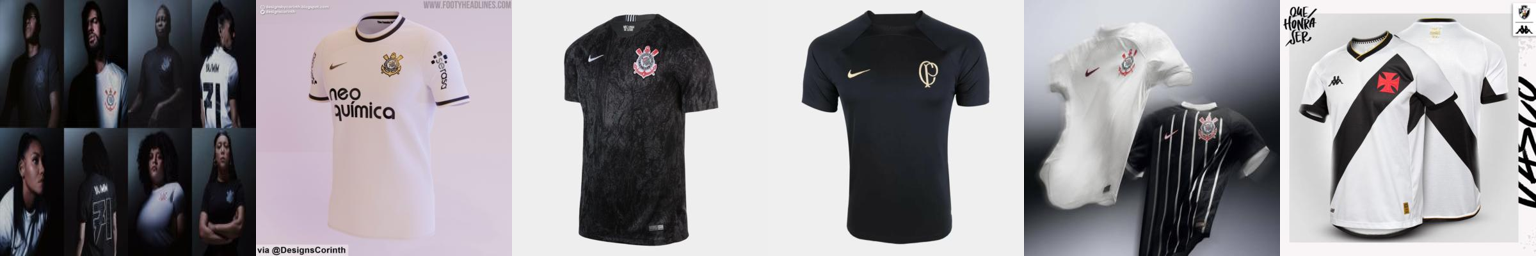

In [41]:
dest = 'botafogo_or_not/Corinthians'

# Get the first six image files from the folder
image_files = sorted([f for f in os.listdir(dest) if f.lower().endswith(('png', 'jpg', 'jpeg', 'gif', 'bmp'))])[:6]

# Open images and resize them
images = [Image.open(os.path.join(dest, img)).resize((256, 256)) for img in image_files]

# Create a blank canvas for the output image
total_width = 256 * len(images)
output_image = Image.new("RGB", (total_width, 256))

# Paste images onto the canvas
for i, img in enumerate(images):
    output_image.paste(img, (i * 256, 0))

# Show the result
output_image.show()

Those are only six out of the 175 images in that folder and we can already see that there's a lot of differences in style, color and even a shirt that belongs to a different team, which leads me to think that the model is having a hard time differentiating between teams because the dataset is confusing even within a single team. For this reason, I've manually cleaned the data and created a second folder: _clean_botafogo_or_not_. 
In this new folder, I'll keep only the images where:

1 - There's a t-shirt clearly visible;

2 - The t-shirt belongs to the correct team;

3 - The front side of the shirt is facing the camera;

4 - The image isn't too low res;

Let's repeat our previous analysis but with the new dataset:

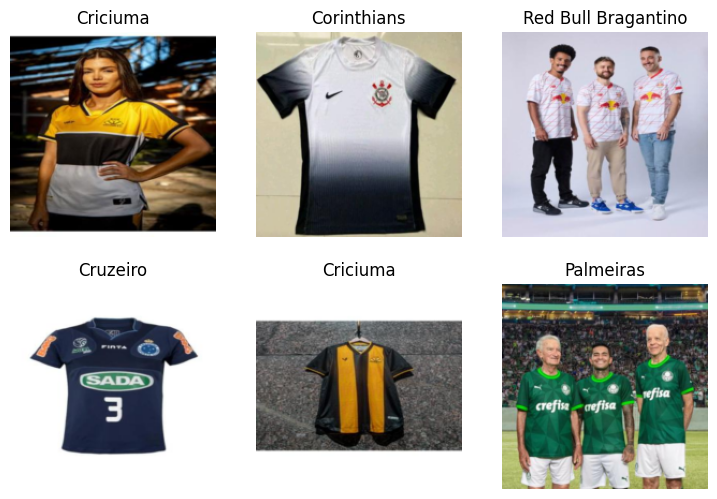

In [43]:
path = Path('clean_botafogo_or_not')

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [44]:
#Train the model for the new dataset
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,3.121965,1.584103,0.444924,00:06


epoch,train_loss,valid_loss,error_rate,time
0,1.442450,1.136457,0.315335,00:07
1,0.965751,0.876270,0.246220,00:07
2,0.595515,0.751018,0.205184,00:07
3,0.318138,0.756376,0.203024,00:07
4,0.178476,0.701491,0.203024,00:07
5,0.098869,0.685834,0.177106,00:07
6,0.062763,0.657139,0.174946,00:07
7,0.036099,0.663888,0.185745,00:07
8,0.027095,0.634737,0.170626,00:07
9,0.020781,0.629613,0.174946,00:07


From the training alone we see that we achieved a significantly lower error rate: 0.1749 vs 0.315642. Let's see how it performs in predicting things:

In [61]:
team_shirt,_,probs = learn.predict(PILImage.create('botafogo_camisa.jpg'))
print(f"This is a: {team_shirt} shirt.")

This is a: Botafogo shirt.


In [65]:
team_shirt,_,probs = learn.predict(PILImage.create('camisa_palmeiras.jpg'))
print(f"This is a: {team_shirt} shirt.")

This is a: Palmeiras shirt.


In [59]:
team_shirt,_,probs = learn.predict(PILImage.create('camisa_criciuma.jpg'))
print(f"This is a: {team_shirt} shirt.")

This is a: Criciuma shirt.


None


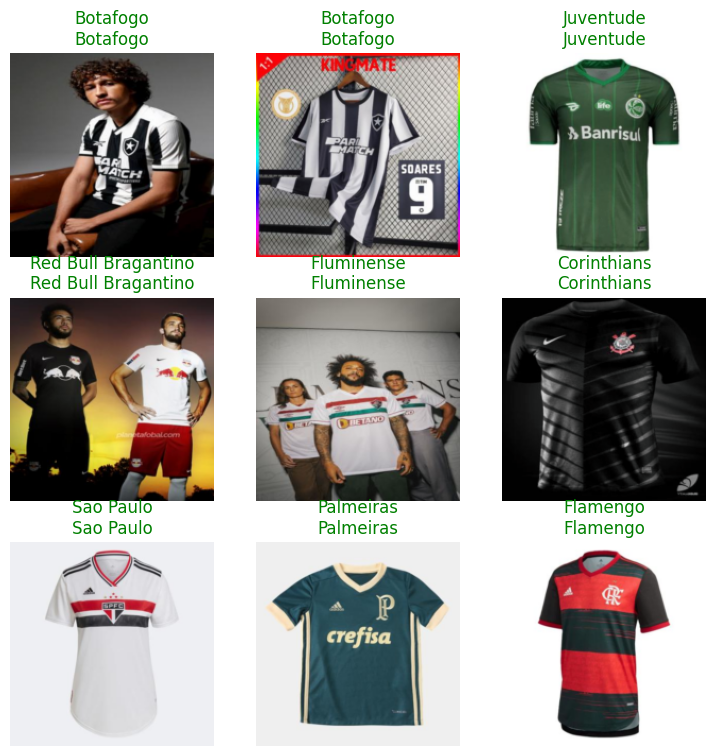

In [52]:
print(learn.show_results())

Awesome! The model can still classify team shirts correctly but with a lot more confidence now. Let's save and export it so we can use it elsewhere.

In [17]:
learn.save("soccer_shirt_classifier") 
learn.export()

**Conclusion**

First thing I can say is: It was very fun working on this! 😄 I was kind of expecting the model to fail hard for teams with similar shirts such as Botafogo and Atletico-MG, but that didn't happen. A nice follow-up exploration would be on to why that's not happening. Both teams have very look-alike striped shirts, so maybe the model sees the difference in the secondary uniforms? Or maybe it has learnt the difference between each team's crests, given that all shirts carry one?
As much as I'm curious to answer those questions, I'll have to stop this project here for now or I'll spend way more time than I should going deeper into this. All in all, it was rather exciting to see a DL model in action. I'm especially surprised by the difference it makes to have proper, cleaned data: We reduced the error rate in half just by eliminating bad data our dataset. It was also super interesting to see that increasing the number of epochs from 10 to 20 in the first training tryout made no difference, actually quite the contrary. 
Last but not least, hope you all found this as interesting as I did while working on it. Maybe someday I'll get the chance to work on this deeper, but for now this is it. 
Thank you for reading!